In [60]:
%config IPCompleter.greedy=True
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, re, math, datetime as dt, pandas as pd, numpy as np, time, random
import logging
import matplotlib.pyplot as plt
from string import Template
from IPython.display import display, HTML
from optionprice import Option

logging.basicConfig(format='%(asctime)s [%(name)s:%(lineno)d:%(funcName)s] [%(levelname)s] %(message)s', level=logging.INFO)

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_colwidth', 5000)
pd.set_option('display.width', 5000)

def display_df(df):
    display(df.head(4))
    print(df.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# from math import * 

# # Cumulative standard normal distribution
# def cdf(x):
#     return (1.0 + erf(x / sqrt(2.0))) / 2.0

# # Intermediate calculation used by both the Bjerksund Stensland 1993 and 2002 approximations
# def phi(s, t, gamma, h, i, r, a, v):
#     lambda1 = (-r + gamma * a + 0.5 * gamma * (gamma - 1) * v**2) * t
#     dd = -(log(s / h) + (a + (gamma - 0.5) * v**2) * t) / (v * sqrt(t))
#     k = 2 * a / (v**2) + (2 * gamma - 1)

#     try:
#         return exp(lambda1) * s**gamma * (cdf(dd) - (i / s)**k * cdf(dd - 2 * log(i / s) / (v * sqrt(t))))
#     except OverflowError as err:
#         return exp(lambda1) * s**gamma * cdf(dd)

# # Call Price based on Bjerksund/Stensland Model
# # Parameters
# #   underlying_price: Price of underlying asset
# #   exercise_price: Exercise price of the option
# #   time_in_years: Time to expiration in years (ie. 33 days to expiration is 33/365)
# #   risk_free_rate: Risk free rate (ie. 2% is 0.02)
# #   volatility: Volatility percentage (ie. 30% volatility is 0.30)
# def bjerksund_stensland_call(underlying_price, exercise_price, time_in_years, risk_free_rate, volatility):
#     div = 1e-08
#     z = 1
#     rr = risk_free_rate
#     dd2 = div
    
#     dt = volatility * sqrt(time_in_years)
#     drift = risk_free_rate - div
#     v2 = volatility**2
    
#     b1 = sqrt((z * drift / v2 - 0.5)**2 + 2 * rr / v2)
#     beta = (1 / 2 - z * drift / v2) + b1
#     binfinity = beta / (beta - 1) * exercise_price
#     bb = max(exercise_price, rr / dd2 * exercise_price)
#     ht = -(z * drift * time_in_years + 2 * dt) * bb / (binfinity - bb)
#     i = bb + (binfinity - bb) * (1 - exp(ht))

#     if underlying_price < i and beta < 100:
#         alpha = (i - exercise_price) * i**(-beta)
#         return alpha * underlying_price**beta - alpha * phi(underlying_price, time_in_years, beta, i, i, rr, z * drift, volatility) + phi(underlying_price, time_in_years, 1, i, i, rr, z * drift, volatility) - phi(underlying_price, time_in_years, 1, exercise_price, i, rr, z * drift, volatility) - exercise_price * phi(underlying_price, time_in_years, 0, i, i, rr, z * drift, volatility) + exercise_price * phi(underlying_price, time_in_years, 0, exercise_price, i, rr, z * drift, volatility)
    
#     return underlying_price - exercise_price

# # Put Price based on Bjerksund/Stensland Model
# # Parameters
# #   underlying_price: Price of underlying asset
# #   exercise_price: Exercise price of the option
# #   time_in_years: Time to expiration in years (ie. 33 days to expiration is 33/365)
# #   risk_free_rate: Risk free rate (ie. 2% is 0.02)
# #   volatility: Volatility percentage (ie. 30% volatility is 0.30)
# def bjerksund_stensland_put(underlying_price, exercise_price, time_in_years, risk_free_rate, volatility):
#     div = 1E-08
#     z = -1
#     rr = div
#     dd = rr
#     dd2 = 2 * dd - rr
#     asset_new = underlying_price
#     underlying_price = exercise_price
#     exercise_price = asset_new

#     dt = volatility * sqrt(time_in_years)
#     drift = risk_free_rate - div
#     v2 = volatility**2

#     b1 = sqrt((z * drift / v2 - 0.5)**2 + 2 * rr / v2)
#     beta = (1 / 2 - z * drift / v2) + b1
#     binfinity = beta / (beta - 1) * exercise_price
#     bb = max(exercise_price, rr / dd2 * exercise_price)
#     ht = -(z * drift * time_in_years + 2 * dt) * bb / (binfinity - bb)
#     i = bb + (binfinity - bb) * (1 - exp(ht))
        
#     if underlying_price < i and beta < 100: # To avoid overflow
#         alpha = (i - exercise_price) * i**(-beta)
#         return alpha * underlying_price**beta - alpha * phi(underlying_price, time_in_years, beta, i, i, rr, z * drift, volatility) + phi(underlying_price, time_in_years, 1, i, i, rr, z * drift, volatility) - phi(underlying_price, time_in_years, 1, exercise_price, i, rr, z * drift, volatility) - exercise_price * phi(underlying_price, time_in_years, 0, i, i, rr, z * drift, volatility) + exercise_price * phi(underlying_price, time_in_years, 0, exercise_price, i, rr, z * drift, volatility)
    
#     return underlying_price - exercise_price    

# # Call Implied Volatility
# # Parameters
# #   underlying_price: Price of underlying asset
# #   exercise_price: Exercise price of the option
# #   time_in_years: Time to expiration in years (ie. 33 days to expiration is 33/365)
# #   risk_free_rate: Risk free rate (ie. 2% is 0.02)
# #   option_price: It is the market price of the option
# def implied_volatility_call(underlying_price, exercise_price, time_in_years, risk_free_rate, option_price):
#     high = 5
#     low = 0

#     while (high - low) > 0.0001:
#         if bjerksund_stensland_call(underlying_price, exercise_price, time_in_years, risk_free_rate, (high + low) / 2) > option_price:
#             high = (high + low) / 2
#         else:
#             low = (high + low) / 2
    
#     return (high + low) / 2

# # Put Implied Volatility
# # Parameters
# #   underlying_price: Price of underlying asset
# #   exercise_price: Exercise price of the option
# #   time_in_years: Time to expiration in years (ie. 33 days to expiration is 33/365)
# #   risk_free_rate: Risk free rate (ie. 2% is 0.02)
# #   option_price: It is the market price of the option
# def implied_volatility_put(underlying_price, exercise_price, time_in_years, risk_free_rate, option_price):
#     high = 5
#     low = 0
    
#     while (high - low) > 0.0001:
#         if bjerksund_stensland_put(underlying_price, exercise_price, time_in_years, risk_free_rate, (high + low) / 2) > option_price:
#             high = (high + low) / 2
#         else:
#             low = (high + low) / 2
    
#     return (high + low) / 2

In [62]:
# underlying_price = 100
# exercise_price = 110
# time_in_years = 1
# risk_free_rate = 0.05

# for i in range(10, 50):
#     volatility = i/200
#     call_price = bjerksund_stensland_call(underlying_price, exercise_price, time_in_years, risk_free_rate, volatility)
#     print(f"{volatility}: {call_price}")

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100  # initial stock price
mu = 0.07  # expected return (drift)
IV = 0.2  # implied volatility (20% annualized)
years = 3
trading_days = 252 * years  # trading days in 3 years

# Compute daily drift and volatility
dt = 1 / 252  # daily time step
daily_drift = (mu - (IV**2) / 2) * dt
daily_volatility = IV * np.sqrt(dt)


* every six months, we buy a synthetic stock, expiry set to six months from now
* every month, we sell a 1-month expiry call with 0-15% higher strike price than current valuation (1/6th quantity of synthetic stock)

In [67]:
def simulate():
    # Simulate stock prices over time
    
    np.random.seed(42)  # for reproducibility
    daily_returns = np.random.normal(daily_drift, daily_volatility, trading_days)
    price_paths = S0 * np.exp(np.cumsum(daily_returns))

    # Plot results
    plt.plot(price_paths)
    plt.title('Stock Price Simulation Over 3 Years')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.show()


In [68]:
%pip install option-price


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


4.390107561825815
6.838399302918816
4.331852710755442
6.74765666681229
5.530461404498759
8.614709977086491
7.356102946160632
11.458482178578521
7.244331948111878
11.284378308826106
8.064016073533978
12.561186968513923
Total synthetic stock return: $461.38
Total premiums collected: $-122.56
Total returns after 3 years: $338.83


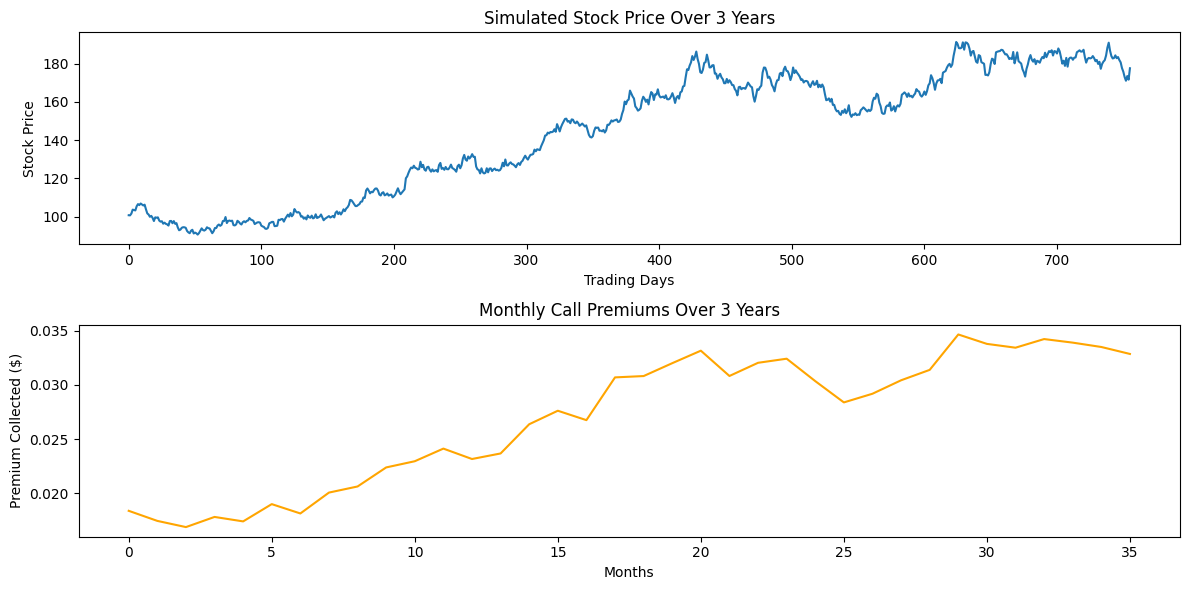

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from optionprice import Option
import datetime

# Parameters for the simulation
initial_stock_price = 100  # Starting stock price
implied_volatility = 0.2   # Annual volatility (20%)
risk_free_rate = 0.05      # Risk-free rate (5%)
dividend_yield = 0         # No dividends
mu = 0.27                 # Expected stock return (7%)
years = 3                  # Simulation period (3 years)
trading_days = 252 * years  # Total trading days over 3 years

# Generate stock price paths (as per previous script)
dt = 1 / 252
daily_drift = (mu - 0.5 * implied_volatility ** 2) * dt
daily_volatility = implied_volatility * np.sqrt(dt)

# Simulate stock prices over time
np.random.seed(42)
daily_returns = np.random.normal(daily_drift, daily_volatility, trading_days)
stock_prices = initial_stock_price * np.exp(np.cumsum(daily_returns))

# Synthetic stock purchase and call selling strategy
synthetic_stock = 0        # Holds the number of synthetic stocks bought
BATCH_SIZE = 6
total_premiums = 0         # Track total premiums earned from selling calls
premium_history = []       # Store the premium each month
stock_value_history = []   # Store synthetic stock value for graphing

# Start date for the simulation
current_date = datetime.datetime.now()

strike_price = None
total_losses = 0

synthetic_returns = None

months = 36  # 3 years = 36 months
for month in range(1, months + 1):
    # Safely get the stock price within bounds of simulated trading days
    current_price = stock_prices[min(month * 21, len(stock_prices) - 1)]
    current_date += datetime.timedelta(days=30)  # Move forward 1 month

    # Every 6 months, buy 6 synthetic stock with a 6-month expiration
    if month % 6 == 1:
        synthetic_stock += BATCH_SIZE
        expiration_date = current_date + datetime.timedelta(days=182)  # 6 months expiration
        synthetic_option_call = Option(european=True, kind='call', s0=current_price, k=current_price, r=risk_free_rate, sigma=implied_volatility, dv=dividend_yield, start=current_date, end=expiration_date)
        synthetic_option_put = Option(european=True, kind='put', s0=current_price, k=current_price, r=risk_free_rate, sigma=implied_volatility, dv=dividend_yield, start=current_date, end=expiration_date)
        print(synthetic_option_put.getPrice())
        print(synthetic_option_call.getPrice())
        total_premiums += synthetic_option_put.getPrice() * BATCH_SIZE
        total_premiums -= synthetic_option_call.getPrice() * BATCH_SIZE # Buy 6 synthetic stocks

    # 100, we own a call with a strike price of 100
    # we sell a call with a strike price of 115, they pay a premium to us
    # if the stock price goes to 130, they will sell their (130-115), so they'll make 15$
    # we will exercise our option, and we'll make (130-100) = 30$, overall, we will make 30-15 + premium

    # If the stock price exceeds the strike price, the call option is exercised
    if strike_price and current_price >= strike_price:
        synthetic_stock -= 1
        total_losses = strike_price - current_price
        

    # Sell a 1-month call every month with strike price 15% higher than current stock price
    strike_price = current_price * 1.15
    expiration_date = current_date + datetime.timedelta(days=30)  # 1 month expiration
    call_option = Option(european=True, kind='call', s0=current_price, k=strike_price, r=risk_free_rate, sigma=implied_volatility, dv=dividend_yield, start=current_date, end=expiration_date)
    premium = call_option.getPrice() * (1)  # Sell 1 call option
    # print(premium)
    total_premiums += premium
    premium_history.append(premium)

# Final value of synthetic stock after 3 years
final_synthetic_stock_return = BATCH_SIZE * (current_price  - stock_prices[0])

# Total returns = final stock value + total premiums earned
total_returns =  final_synthetic_stock_return + total_premiums

# Print results
# print("Total synthetic stock bought:", synthetic_stock)
# print(f"Final value of synthetic stock: ${final_synthetic_stock_value:.2f}")
print(f"Total synthetic stock return: ${final_synthetic_stock_return:.2f}")
print(f"Total premiums collected: ${total_premiums:.2f}")
print(f"Total returns after 3 years: ${total_returns:.2f}")

# Plot stock prices and premium history
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(stock_prices)
plt.title('Simulated Stock Price Over 3 Years')
plt.xlabel('Trading Days')
plt.ylabel('Stock Price')


plt.subplot(2, 1, 2)
plt.plot(premium_history, color='orange')
plt.title('Monthly Call Premiums Over 3 Years')
plt.xlabel('Months')
plt.ylabel('Premium Collected ($)')

plt.tight_layout()
plt.show()



* every six months, we buy a synthetic stock, expiry set to six months from now
* every month, we sell a 1-month expiry call with 0-15% higher strike price than current valuation